# Import necessary packages

In [2]:
#!pip install git+https://github.com/fspinna/borf.git@xai-improvements

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline

plt.style.use('default')

# Load single cell data

In [4]:
data = pd.read_csv("temporal_data_with_patient_ready_normalized_full_genes.csv", index_col=0)
data = data.dropna(axis=0)

In [5]:
# remove rows containing only zeros
data = data.loc[(data.iloc[:, 1:] != 0).any(axis=1)]

data.shape

(3086347, 6)

In [6]:
# remove a layer of complexity by averaging the data across patients for each gene and celltype
data.index = data.index.str.split('_').map(lambda x: (x[0], x[-1]))
data.index = pd.MultiIndex.from_tuples(data.index, names=["gene", "celltype"])
data_avg = data.groupby(level=["gene", "celltype"]).mean()

# fix the index
data_avg = data_avg.reset_index()
data_avg["gene_celltype"] = data_avg["gene"] + "_" + data_avg["celltype"]
data_avg = data_avg.set_index("gene_celltype").drop(columns=["gene", "celltype"])

print(data_avg.head())


                                d0        d1        d2        d5        d9  \
gene_celltype                                                                
A1BG_Bcells               0.196337  0.235422  0.229986  0.329739  0.465127   
A1BG_CD4cytotoxicT        0.000000  0.265965  0.218069  0.269721  0.445299   
A1BG_CD4memoryT           0.211437  0.208521  0.167145  0.225112  0.305198   
A1BG_CD4memoryactivatedT  0.223909  0.211382  0.183420  0.380808  0.379326   
A1BG_CD4naiveT            0.178656  0.179129  0.212789  0.095340  0.089639   

                               d15  
gene_celltype                       
A1BG_Bcells               0.365523  
A1BG_CD4cytotoxicT        0.266964  
A1BG_CD4memoryT           0.187713  
A1BG_CD4memoryactivatedT  0.353488  
A1BG_CD4naiveT            0.111972  


In [14]:
# load genes in PPI
ppi_genes = pd.read_csv("hotnet2/paper/data/networks/hint+hi2012/hint+hi2012_index_gene", header=None, sep=" |\t")
ppi_genes = ppi_genes[1].values

# filter data to only include genes in PPI
data_avg = data_avg.loc[data_avg.index.str.split('_').str[0].isin(ppi_genes)]

/tmp/ipykernel_1717995/1274773203.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ppi_genes = pd.read_csv("hotnet2/paper/data/networks/hint+hi2012/hint+hi2012_index_gene", header=None, sep=" |\t")


In [15]:
data_avg.shape

(162085, 6)

In [16]:
data = data_avg

columns = data.columns
genes = np.array([name.split("_")[0] for name in list(data.index)])
cells = np.array([name.split("_")[1] for name in list(data.index)])

enc_genes = LabelEncoder()
enc_cells = LabelEncoder()

enc_genes.fit(genes)
enc_cells.fit(cells)

X = data.values[:, np.newaxis, :]

y_genes = enc_genes.transform(genes)
y_cells = enc_cells.transform(cells)

X.shape, y_genes.shape, y_cells.shape, genes.shape, cells.shape

((162085, 1, 6), (162085,), (162085,), (162085,), (162085,))

In [17]:
len(np.unique(genes))

8768

## BORF

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeClassifier
import numpy as np
from fast_borf import BorfBuilder
from fast_borf.pipeline.zero_columns_remover import ZeroColumnsRemover
from fast_borf.pipeline.reshaper import ReshapeTo2D
from fast_borf.pipeline.to_scipy import ToScipySparse
from fast_borf.xai.mapping import BagOfReceptiveFields
from constants import CUSTOM_CONFIG_A3, CUSTOM_CONFIG_A3_NO_DILATION, CUSTOM_CONFIG_A3_NO_DILATION_WINDOW_SIZE_2_3_4

In [19]:
# Setup the BORF builder
builder = BorfBuilder(
    n_jobs=-2, window_size_min_window_size=None, alphabets_min_symbols=None, alphabets_max_symbols=None, min_window_to_signal_std_ratio=0.15, configs=CUSTOM_CONFIG_A3_NO_DILATION_WINDOW_SIZE_2_3_4,
    pipeline_objects=[
        (ReshapeTo2D, dict(keep_unraveled_index=True)),
        (ZeroColumnsRemover, dict(axis=0)),
        (ToScipySparse, dict()),
        ],
)
borf = builder.build(X)

In [20]:
builder.configs_

[{'window_size': 2,
  'stride': 1,
  'dilation': 1,
  'word_length': 2,
  'alphabet_size': 3},
 {'window_size': 3,
  'stride': 1,
  'dilation': 1,
  'word_length': 3,
  'alphabet_size': 3},
 {'window_size': 4,
  'stride': 1,
  'dilation': 1,
  'word_length': 2,
  'alphabet_size': 3},
 {'window_size': 4,
  'stride': 1,
  'dilation': 1,
  'word_length': 4,
  'alphabet_size': 3}]

In [21]:
%%time
X_transformed = borf.fit_transform(X)
X_transformed.shape

CPU times: user 162 ms, sys: 2.11 s, total: 2.27 s
Wall time: 9.08 s


(162085, 70)

In [22]:
X_transformed_sorted = X_transformed.toarray()[np.argsort(cells)]
X_transformed_sorted = X_transformed_sorted[:, np.argsort(X_transformed.toarray()[np.argsort(cells)].mean(axis=0).ravel())[::-1]]
X_transformed_sorted

array([[1, 1, 3, ..., 0, 0, 0],
       [1, 2, 2, ..., 0, 0, 0],
       [2, 1, 2, ..., 0, 0, 0],
       ...,
       [3, 1, 1, ..., 0, 0, 0],
       [3, 0, 2, ..., 0, 0, 0],
       [2, 2, 1, ..., 0, 0, 0]])

In [23]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_transformed, y_genes)

DecisionTreeClassifier()

In [24]:
from sklearn.metrics import precision_score
accuracy = precision_score(y_genes, clf.predict(X_transformed.astype(float)), average='micro')
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.2055


In [25]:
# how many times higher is the accuracy compared to random guessing
accuracy / (1/len(np.unique(genes)))

1801.90690070025

In [26]:
np.unique(y_genes, return_counts=True)

(array([   0,    1,    2, ..., 8765, 8766, 8767]),
 array([20, 16, 20, ..., 20, 20, 20]))

In [27]:
# get all row indexes of X_transformed corresponding to one cell type
cell_type = "CIKcells"
cell_type_indexes = np.where(enc_cells.inverse_transform(y_cells) == cell_type)[0]
cell_type_indexes

array([    10,     29,     46, ..., 162035, 162055, 162075])

In [28]:
X_transformed.toarray()[cell_type_indexes].shape

(8145, 70)

In [29]:
np.unique(X_transformed.indices)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69], dtype=int32)

In [35]:
import fasttreeshap
shap_explainer = fasttreeshap.TreeExplainer(clf, algorithm = 'auto', n_jobs = -1)
shap_values = shap_explainer(X_transformed.toarray()[cell_type_indexes], check_additivity=False).values

In [36]:
enc_genes.classes_.astype(str)

array(['A1BG', 'A1CF', 'A2M', ..., 'ZXDC', 'ZYX', 'ZZEF1'], dtype='<U10')

In [37]:
# Aggregation methods
average = np.mean(abs(shap_values), axis=0)  # Shape: (74, 2000)
maximum = np.max(abs(shap_values), axis=0)   # Shape: (74, 2000)
summation = np.sum(abs(shap_values), axis=0) # Shape: (74, 2000)

average_df = pd.DataFrame(average, columns = enc_genes.classes_.astype(str))
print("Done with average")
maximum_df = pd.DataFrame(maximum, columns = enc_genes.classes_.astype(str))
print("Done with maximum")
summation_df = pd.DataFrame(summation, columns = enc_genes.classes_.astype(str))
print("Done with summation")

Done with average
Done with maximum
Done with summation


In [38]:
average_df.shape, maximum_df.shape, summation_df.shape

((70, 8768), (70, 8768), (70, 8768))

In [39]:
# find max value in each column
max_average = average_df.max()
max_maximum = maximum_df.max()
max_summation = summation_df.max()

In [40]:
# create folder with shap values
import os
if not os.path.exists("shap_values"):
    os.makedirs("shap_values")

In [41]:
average_df.to_csv("shap_values/shap_values_CIK_cells_average.csv", index=False)
maximum_df.to_csv("shap_values/shap_values_CIK_cells_maximum.csv", index=False)
summation_df.to_csv("shap_values/shap_values_CIK_cells_summation.csv", index=False)

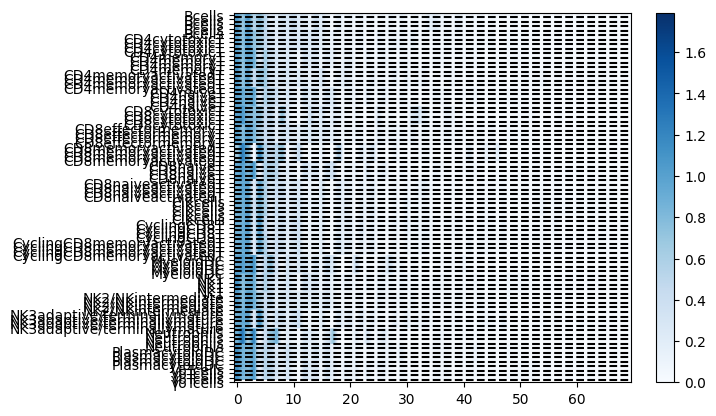

In [42]:

plt.imshow(np.log1p(X_transformed_sorted), cmap="Blues", aspect="auto")

plt.gca().set_yticks(np.arange(0, len(cells), 2000)+1000)
plt.gca().set_yticklabels(cells[np.argsort(cells)][::2000])

for i in range(0, len(cells), 2000):
    plt.axhline(y=i, color='k', linestyle='--')
plt.colorbar()

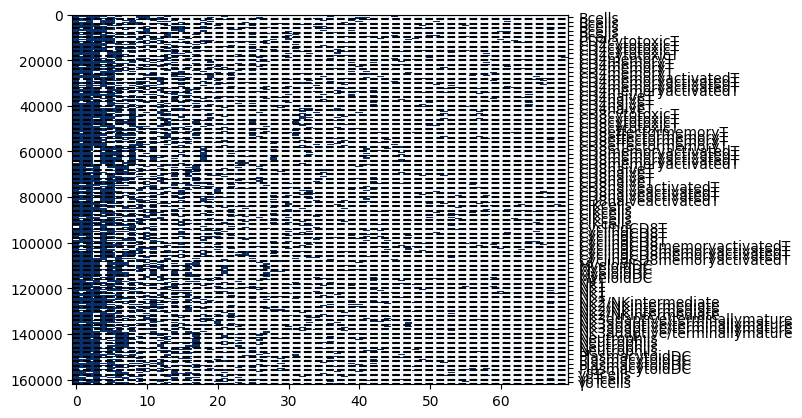

In [43]:
plt.imshow((X_transformed_sorted>0)*1, cmap="Blues", aspect="auto", interpolation="none")

# plt.axhline(y=i, color='k', linestyle='--')
secax = plt.gca().secondary_yaxis('right')  # Adds a secondary x-axis at the top
secax.set_yticks(np.arange(0, len(cells), 2000)+1000)  # Set ticks every 2000
secax.set_yticklabels(cells[np.argsort(cells)][::2000])

for i in range(0, len(cells), 2000):
    plt.axhline(y=i, color='k', linestyle='--')
# plt.xscale("log")

In [44]:
mapper = BagOfReceptiveFields(borf)
mapper.build(X)

unsafe cast from int64 to uint64. Precision may be lost.


In [46]:
mapper.mapping.shape

(70, 3)

In [47]:
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF file
with PdfPages('mappings.pdf') as pdf:
  for i in range(70):
    plt.figure()
    plt.plot(mapper[i].word_array, marker="o")
    plt.title(f'Mapping row_{i}')
    pdf.savefig()  # Save the current figure into the PDF
    plt.close()  # Close the figure to free memory

In [48]:
mapper[i].alignments[0]
mapper[i].mappings[0]

array([], shape=(0, 4, 1), dtype=int64)

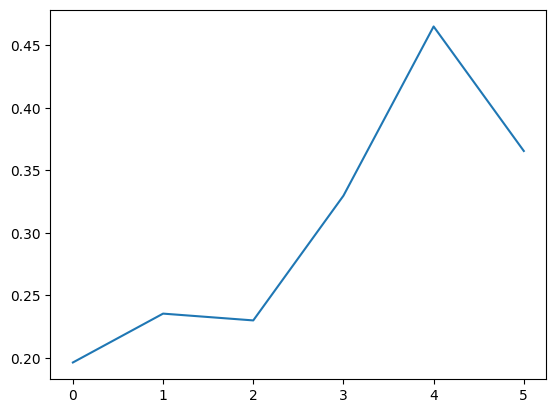

In [49]:

plt.plot(X[0, 0])
plt.plot(mapper[i].alignments[0].ravel(), mapper[i].mappings[0].ravel() )

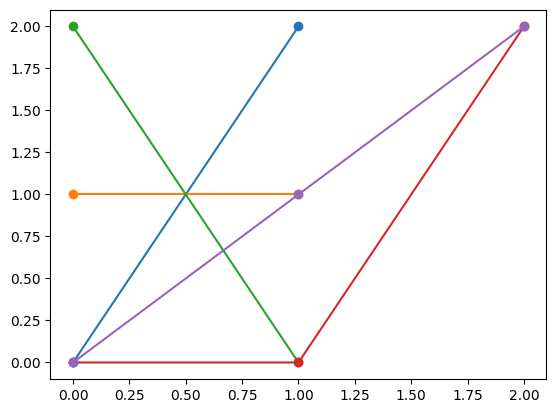

In [50]:
for i in range(5):
    plt.plot(mapper[i].word_array, marker="o")